In [76]:
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import integrate
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve


conn = create_engine('postgresql://ubuntu@52.53.236.232:5432/collegesc')

%matplotlib inline

## Helper functions and other definitions

In [77]:
def query_data_def(conn, var_name):
    """
    var_name: name of column to query
    returns query from datadefinitions table showing definition of data
    """
    query = "SELECT * FROM datadefinitions WHERE developername='"+var_name+"';"
    return conn.execute(query).fetchall()

def check_highnull_columns(df, threshold=1000):
    """
    takes a dataframe and checks which columns
    have lower than threshold nulls
    returns partial dataframe with columns with low nulls
    """
    return df.loc[:, df.isnull().sum() < threshold]


def fit_and_show_metrics(model_dict, X_train, X_test, y_train, y_test):
    """
    Takes a dictionary of models, the training and test sets,
    and plots their ROC and Precision-Recall curves
    Then, returns the fitted models
    """
    for key in model_dict.keys():
        model_dict[key].fit(X_train, y_train)
        model_prob = model_dict[key].predict_proba(X_test)[:, 1]
    

        fpr, tpr, thresholds = roc_curve(y_test, model_prob)
        auc_score = integrate.trapz(tpr, x=fpr)
        
        prec, recall, thresholds = precision_recall_curve(y_test, model_prob)
        
        model_ll = log_loss(y_test, model_prob)
        
        print(key)
        print("AUC score: {}".format(auc_score))
        print("Log loss: {}".format(model_ll))
        
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        fig.suptitle(key)
        axes[0].plot(fpr, tpr)
        axes[0].plot(np.linspace(0,1,3),np.linspace(0,1,3))
        axes[0].set_xlabel("False Positive Rate")
        axes[0].set_ylabel("True Positive Rate")
        
        axes[1].plot(prec, recall)
        axes[1].set_xlabel("Precision")
        axes[1].set_ylabel("Recall")
        
        plt.show()
        

    return model_dict


## Start with school table

In [78]:
school_all = """SELECT * FROM school;"""

In [79]:
school_df = pd.read_sql_query(school_all, conn)

In [80]:
school_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7703 entries, 0 to 7702
Data columns (total 43 columns):
index                                   7703 non-null int64
id                                      7703 non-null int64
location.lat                            7703 non-null float64
location.lon                            7703 non-null float64
accreditor                              6805 non-null object
alias                                   2178 non-null object
branches                                7703 non-null int64
carnegie_basic                          7282 non-null float64
carnegie_size_setting                   7282 non-null float64
carnegie_undergrad                      7282 non-null float64
city                                    7703 non-null object
degree_urbanization                     0 non-null object
degrees_awarded.highest                 7703 non-null int64
degrees_awarded.predominant             7703 non-null int64
degrees_awarded.predominant_recoded     0 

In [81]:
school_df.operating.value_counts()

1    6893
0     810
Name: operating, dtype: int64

### Remove uninteresting columns or columns with explicit or encoded nulls

In [82]:
school_columns = list(school_df.columns.values)

In [83]:
school_columns.remove('index')
school_columns.remove('alias')
school_columns.remove('degree_urbanization')
school_columns.remove('degrees_awarded.predominant_recoded')
school_columns.remove('faculty_salary')
school_columns.remove('ft_faculty_rate')
school_columns.remove('price_calculator_url')
school_columns.remove('url')
school_columns.remove('zip')
school_columns.remove('carnegie_basic')
school_columns.remove('carnegie_size_setting')
school_columns.remove('carnegie_undergrad')
school_columns.remove('online_only')
school_columns.remove('accreditor')
school_columns.remove('under_investigation')

## Get columns from student table next

In [84]:
student_all = "SELECT * FROM student;"

In [85]:
student_df = pd.read_sql_query(student_all, conn)

In [86]:
student_lownull_df = check_highnull_columns(student_df, threshold=2000)

In [87]:
student_lownull_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7703 entries, 0 to 7702
Data columns (total 39 columns):
index                                             7703 non-null int64
FAFSA_applications                                7204 non-null float64
avg_dependent_income.2014dollars                  6835 non-null float64
avg_independent_income.2014dollars                6835 non-null float64
demographics.age_entry                            7204 non-null float64
demographics.avg_family_income                    7204 non-null float64
demographics.avg_family_income_independents       6835 non-null float64
demographics.dependent                            6829 non-null float64
demographics.female_share                         6259 non-null float64
demographics.first_generation                     6534 non-null float64
demographics.married                              6495 non-null float64
demographics.median_family_income                 7204 non-null float64
demographics.men               

In [88]:
student_lownull_df['parents_education_level'].describe()

count      6568.000000
mean       4959.635201
std       12477.427315
min          11.000000
25%         320.000000
50%        1074.000000
75%        3380.000000
max      136770.000000
Name: parents_education_level, dtype: float64

In [89]:
student_lownull = list(student_lownull_df.columns.values)

In [90]:
student_lownull.remove('index')
student_lownull.remove('avg_dependent_income.2014dollars')
student_lownull.remove('demographics.avg_family_income')
student_lownull.remove('demographics.avg_family_income_independents')
student_lownull.remove('avg_independent_income.2014dollars')
student_lownull.remove('FAFSA_applications')
student_lownull.remove('family_income.dependent_students')
student_lownull.remove('family_income.independent_students')
student_lownull.remove('family_income.overall')
student_lownull.remove('valid_dependency_status')
student_lownull.remove('parents_education_level')
student_lownull.remove('id')
student_lownull.remove('students_with_pell_grant')
student_lownull

['demographics.age_entry',
 'demographics.dependent',
 'demographics.female_share',
 'demographics.first_generation',
 'demographics.married',
 'demographics.median_family_income',
 'demographics.men',
 'demographics.race_ethnicity.aian',
 'demographics.race_ethnicity.asian',
 'demographics.race_ethnicity.black',
 'demographics.race_ethnicity.hispanic',
 'demographics.race_ethnicity.nhpi',
 'demographics.race_ethnicity.non_resident_alien',
 'demographics.race_ethnicity.two_or_more',
 'demographics.race_ethnicity.unknown',
 'demographics.race_ethnicity.white',
 'demographics.women',
 'fafsa_sent.2_college_allyrs',
 'part_time_share',
 'share_25_older',
 'share_firstgeneration',
 'share_firstgeneration_parents.somecollege',
 'share_independent_students',
 'share_lowincome.0_30000',
 'share_middleincome.30001_48000',
 'size']

## Select only interesting features and add/recode features

In [91]:
operating_query = 'SELECT \n school."' + '",school."'.join(school_columns) + '",repayment."3_yr_default_rate"'
operating_query += ', aid."federal_loan_rate", aid."pell_grant_rate",student."'
operating_query += '",student."'.join(student_lownull)+'"'
operating_query += """                       
                    FROM 
                        school
                    JOIN repayment ON school.id=repayment.id
                    JOIN aid ON school.id=aid.id
                    JOIN student ON school.id=student.id;"""
operating_query

'SELECT \n school."id",school."location.lat",school."location.lon",school."branches",school."city",school."degrees_awarded.highest",school."degrees_awarded.predominant",school."institutional_characteristics.level",school."instructional_expenditure_per_fte",school."locale",school."main_campus",school."men_only",school."minority_serving.aanipi",school."minority_serving.annh",school."minority_serving.hispanic",school."minority_serving.historically_black",school."minority_serving.nant",school."minority_serving.predominantly_black",school."minority_serving.tribal",school."name",school."operating",school."ownership",school."region_id",school."religious_affiliation",school."state",school."state_fips",school."tuition_revenue_per_fte",school."women_only",repayment."3_yr_default_rate", aid."federal_loan_rate", aid."pell_grant_rate",student."demographics.age_entry",student."demographics.dependent",student."demographics.female_share",student."demographics.first_generation",student."demographics.ma

In [92]:
school_df = pd.read_sql_query(operating_query, conn)

In [93]:
school_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7703 entries, 0 to 7702
Data columns (total 57 columns):
id                                                7703 non-null int64
location.lat                                      7703 non-null float64
location.lon                                      7703 non-null float64
branches                                          7703 non-null int64
city                                              7703 non-null object
degrees_awarded.highest                           7703 non-null int64
degrees_awarded.predominant                       7703 non-null int64
institutional_characteristics.level               7703 non-null int64
instructional_expenditure_per_fte                 7270 non-null float64
locale                                            7282 non-null float64
main_campus                                       7703 non-null int64
men_only                                          7282 non-null float64
minority_serving.aanipi                   

### Check to make sure not too many nulls are associated with not operating

In [94]:
operating_df = school_df.loc[school_df.operating==1]
operating_df.isnull().sum().sum()/operating_df.size

0.071949422373575017

In [95]:
not_operating_df = school_df.loc[school_df.operating==0]
not_operating_df.isnull().sum().sum()/not_operating_df.size

0.097357591509638297

### Recode locale to 4 values instead of 12

In [96]:
locale_recode = school_df.locale.astype(str).values

In [97]:
locale_recode = [int(x[0]) if x[0] in ['1','2','3'] else 0 for x in locale_recode]

In [98]:
school_df['locale_recode'] = locale_recode

In [99]:
school_df['locale_recode'].value_counts()

1    3509
2    2291
0     986
3     917
Name: locale_recode, dtype: int64

### Recode religion to religious and non-religious

In [100]:
religion_recode = (np.nan_to_num(school_df.religious_affiliation.values) > 0).astype(int)

In [101]:
np.unique(religion_recode)

array([0, 1])

In [102]:
school_df['religion_recode'] = religion_recode

In [103]:
school_df.religion_recode.value_counts()

0    6793
1     910
Name: religion_recode, dtype: int64

### Recode gender-specific schools

In [104]:
school_df['gender_specific'] = np.nan_to_num((school_df.men_only + school_df.women_only).values)

In [105]:
school_df.gender_specific.value_counts()

0.0    7598
1.0     105
Name: gender_specific, dtype: int64

### Recode minority-serving schools

In [106]:
minority_specific = np.nan_to_num((school_df['minority_serving.aanipi'] +\
                        school_df['minority_serving.annh'] +\
                        school_df['minority_serving.hispanic'] +\
                        school_df['minority_serving.historically_black'] +\
                        school_df['minority_serving.nant'] +\
                        school_df['minority_serving.predominantly_black'] +\
                        school_df['minority_serving.tribal']).values)

In [107]:
minority_specific = (minority_specific > 0).astype(int)

In [108]:
school_df['minority_specific'] = minority_specific

### Recode for-profit vs. non-profit (private or public)

In [109]:
school_df['for_profit'] = (school_df.ownership == 3).astype(int)

In [110]:
school_df.for_profit.value_counts()

0    4000
1    3703
Name: for_profit, dtype: int64

### Impute continuous variables with mean

In [111]:
continuous_vars = ['instructional_expenditure_per_fte', 'tuition_revenue_per_fte', '3_yr_default_rate',
                  'federal_loan_rate', 'pell_grant_rate', 'demographics.age_entry', 
                  'demographics.dependent', 'demographics.female_share', 'demographics.married',
                  'demographics.median_family_income', 'demographics.race_ethnicity.aian',
                   'demographics.race_ethnicity.asian','demographics.race_ethnicity.black',
                   'demographics.race_ethnicity.hispanic','demographics.race_ethnicity.nhpi',
                   'demographics.race_ethnicity.non_resident_alien',
                   'demographics.race_ethnicity.two_or_more',
                   'demographics.race_ethnicity.unknown','demographics.race_ethnicity.white',
                   'fafsa_sent.2_college_allyrs', 'part_time_share','share_25_older',
                   'share_firstgeneration','share_firstgeneration_parents.somecollege',
                   'share_independent_students','share_lowincome.0_30000',
                   'share_middleincome.30001_48000','size']


In [112]:
for var in continuous_vars:
    school_df[var].fillna(school_df[var].mean(), inplace=True)
    

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


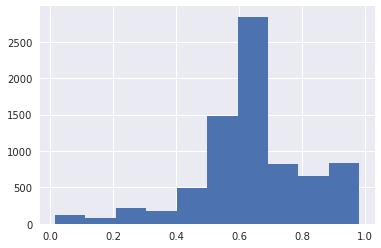

In [113]:
school_df['demographics.female_share'].hist()

In [114]:
school_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7703 entries, 0 to 7702
Data columns (total 62 columns):
id                                                7703 non-null int64
location.lat                                      7703 non-null float64
location.lon                                      7703 non-null float64
branches                                          7703 non-null int64
city                                              7703 non-null object
degrees_awarded.highest                           7703 non-null int64
degrees_awarded.predominant                       7703 non-null int64
institutional_characteristics.level               7703 non-null int64
instructional_expenditure_per_fte                 7703 non-null float64
locale                                            7282 non-null float64
main_campus                                       7703 non-null int64
men_only                                          7282 non-null float64
minority_serving.aanipi                   

### Pare down to relevant columns

In [115]:
cleaned_school_df = school_df.drop(['locale', 'men_only',
                                    'minority_serving.aanipi', 'minority_serving.annh',
                                    'minority_serving.hispanic', 'minority_serving.historically_black',
                                    'minority_serving.nant', 'minority_serving.predominantly_black',
                                    'minority_serving.tribal', 'religious_affiliation', 'state', 
                                    'state_fips','women_only', 'demographics.men',
                                    'demographics.women', 'demographics.first_generation'], axis = 1)

In [116]:
cleaned_school_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7703 entries, 0 to 7702
Data columns (total 46 columns):
id                                                7703 non-null int64
location.lat                                      7703 non-null float64
location.lon                                      7703 non-null float64
branches                                          7703 non-null int64
city                                              7703 non-null object
degrees_awarded.highest                           7703 non-null int64
degrees_awarded.predominant                       7703 non-null int64
institutional_characteristics.level               7703 non-null int64
instructional_expenditure_per_fte                 7703 non-null float64
main_campus                                       7703 non-null int64
name                                              7703 non-null object
operating                                         7703 non-null int64
ownership                                    

In [117]:
cleaned_school_df['not_operating'] =  1 - cleaned_school_df.operating

In [118]:
cleaned_school_df.not_operating.value_counts()

0    6893
1     810
Name: not_operating, dtype: int64

## Select columns for classification


In [119]:
X = cleaned_school_df.drop(['id', 'city', 'name', 'ownership', 'region_id', 'operating', 'not_operating'], axis = 1)
y = cleaned_school_df.not_operating

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


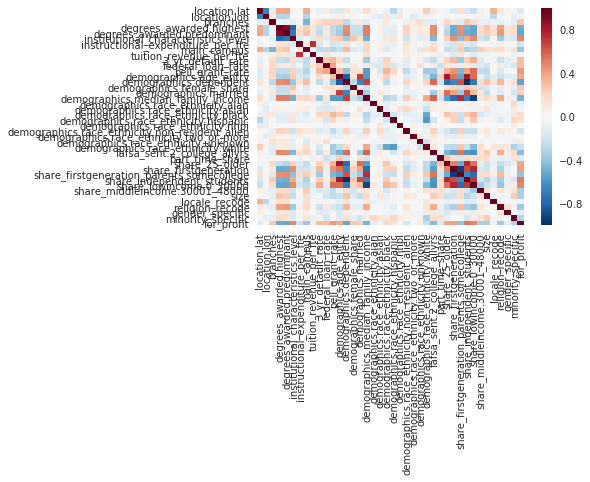

In [120]:
sns.heatmap(X.corr())

### Split data, run several models

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [122]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression



In [123]:
models = dict()
models['Logistic L1'] = LogisticRegression(penalty='l1', C=0.5)
models['Logistic L2'] = LogisticRegression(C=0.5)
models['KNN'] = KNeighborsClassifier(n_neighbors=6)
models['Tree'] = DecisionTreeClassifier()
models['RandomForest'] = RandomForestClassifier(n_estimators=1000)
models['GradBoostTrees'] = GradientBoostingClassifier()

Logistic L1
AUC score: 0.8137149582540145
Log loss: 0.2742106233041431


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


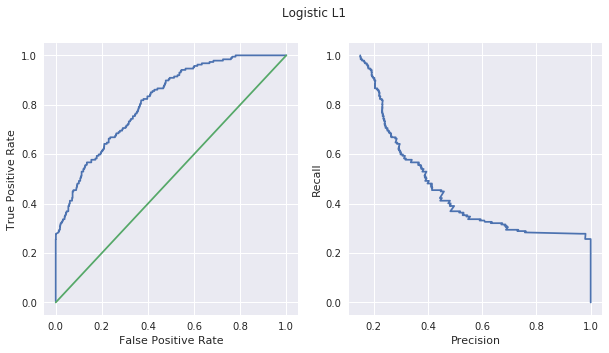

Logistic L2
AUC score: 0.7947772099305682
Log loss: 0.2840603453341495


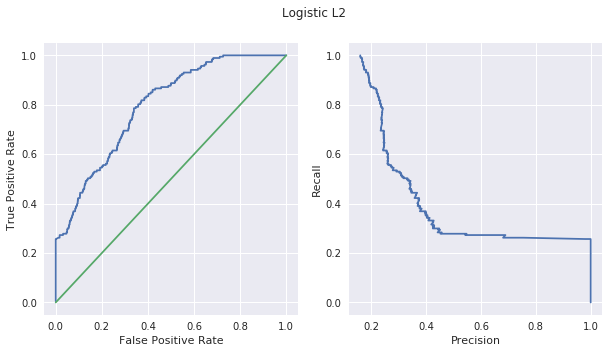

KNN
AUC score: 0.7476994289054415
Log loss: 1.5695637681502665


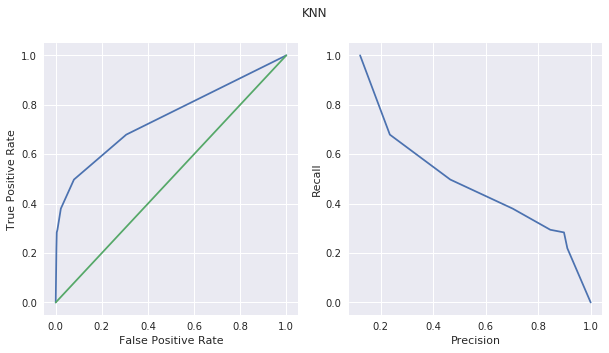

Tree
AUC score: 0.7173911326313793
Log loss: 3.947953154588285


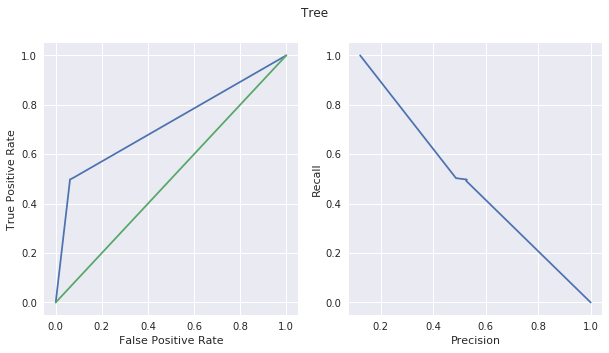

RandomForest
AUC score: 0.8946397680866357
Log loss: 0.2509968208456705


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


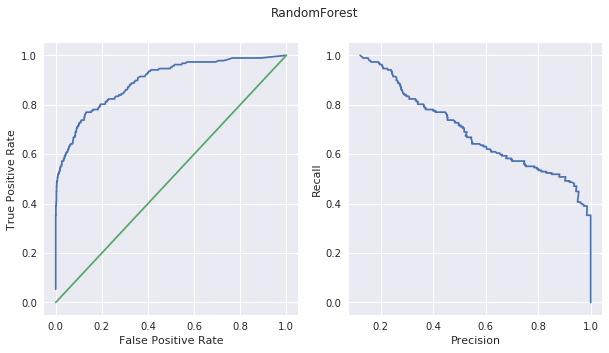

GradBoostTrees
AUC score: 0.8755341669365477
Log loss: 0.23397244899750944


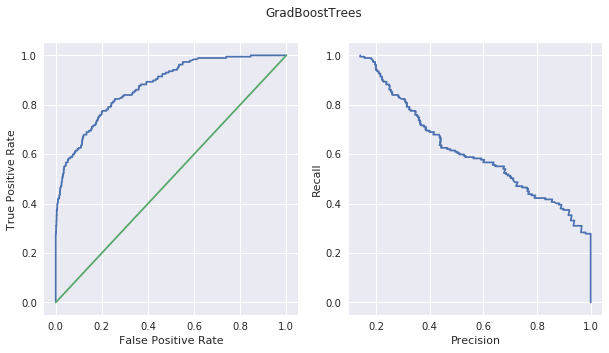

In [124]:
fit_models = fit_and_show_metrics(models, X_train, X_test, y_train, y_test)

### Check features in best models

In [127]:
lasso_log_coef = sorted(list(zip(X.columns, fit_models['Logistic L1'].coef_[0])), key = lambda x: x[1], reverse=True)
lasso_log_coef

[('demographics.race_ethnicity.unknown', 2.9537444224541631),
 ('share_25_older', 1.5058813236224364),
 ('3_yr_default_rate', 1.4409679469617434),
 ('pell_grant_rate', 0.66918929004266925),
 ('fafsa_sent.2_college_allyrs', 0.53056463919694508),
 ('for_profit', 0.39999746089458421),
 ('demographics.race_ethnicity.two_or_more', 0.35537273708007677),
 ('institutional_characteristics.level', 0.24786836916727914),
 ('demographics.female_share', 0.13156929772850667),
 ('religion_recode', 0.092237101154727871),
 ('federal_loan_rate', 0.066615905876077242),
 ('branches', 0.029942409621331205),
 ('location.lat', 0.0024910679125666794),
 ('location.lon', 0.0015474921527855736),
 ('tuition_revenue_per_fte', 2.155046227672381e-05),
 ('instructional_expenditure_per_fte', 1.6762211210289353e-06),
 ('demographics.dependent', 0.0),
 ('demographics.married', 0.0),
 ('demographics.race_ethnicity.aian', 0.0),
 ('demographics.race_ethnicity.asian', 0.0),
 ('demographics.race_ethnicity.black', 0.0),
 ('dem

In [128]:
rf_feat_imp = sorted(list(zip(X.columns, fit_models['RandomForest'].feature_importances_)), key = lambda x: x[1], reverse=True)
rf_feat_imp

[('branches', 0.11954880290894493),
 ('demographics.female_share', 0.050715127668557534),
 ('demographics.median_family_income', 0.047362634859644828),
 ('3_yr_default_rate', 0.039288995903746148),
 ('tuition_revenue_per_fte', 0.035224840295034275),
 ('share_lowincome.0_30000', 0.033788481368195733),
 ('share_firstgeneration', 0.033506433766197045),
 ('pell_grant_rate', 0.033181767761260465),
 ('demographics.race_ethnicity.unknown', 0.031835245531758358),
 ('demographics.dependent', 0.031831368546889907),
 ('share_independent_students', 0.031562557891262222),
 ('instructional_expenditure_per_fte', 0.031371472401525803),
 ('location.lat', 0.030948180221277634),
 ('size', 0.030941424097149828),
 ('share_firstgeneration_parents.somecollege', 0.029862970753521571),
 ('share_middleincome.30001_48000', 0.028576192850444698),
 ('location.lon', 0.028350164708706056),
 ('demographics.married', 0.027846101804368004),
 ('fafsa_sent.2_college_allyrs', 0.025863203274087896),
 ('federal_loan_rate', 

In [129]:
sorted(list(zip(X.columns, fit_models['GradBoostTrees'].feature_importances_)), key = lambda x: x[1], reverse=True)

[('branches', 0.16314082175212627),
 ('fafsa_sent.2_college_allyrs', 0.065893758919356449),
 ('tuition_revenue_per_fte', 0.052909594498387176),
 ('demographics.median_family_income', 0.05083113414006827),
 ('demographics.race_ethnicity.unknown', 0.049883605875017036),
 ('share_middleincome.30001_48000', 0.048737123230701417),
 ('3_yr_default_rate', 0.046696817884079832),
 ('demographics.female_share', 0.042574533100276174),
 ('size', 0.041711041123640956),
 ('instructional_expenditure_per_fte', 0.035932139119859541),
 ('location.lat', 0.032775695718364216),
 ('share_lowincome.0_30000', 0.032489892728760295),
 ('share_firstgeneration_parents.somecollege', 0.031612236367175854),
 ('demographics.race_ethnicity.two_or_more', 0.02400508901097155),
 ('pell_grant_rate', 0.02374132384226578),
 ('demographics.race_ethnicity.white', 0.020144130117947853),
 ('demographics.race_ethnicity.hispanic', 0.019617336370737402),
 ('demographics.race_ethnicity.black', 0.01954704927887433),
 ('for_profit', 

Both random forest and gradient boosted trees latched onto "branches" since 144 of the schools that closed were the branches of ITT Tech. Try running again without ITT Tech.

In [130]:
cleaned_school_df.loc[cleaned_school_df.branches > 60, ['name', 'not_operating', 'branches']].head(10)

,name,not_operating,branches
31,ITT Technical Institute-Albany,1,142
32,ITT Technical Institute-Liverpool,1,142
45,ITT Technical Institute-Saint Rose,1,142
138,Strayer University-Cedar Hill,0,80
139,Strayer University-North Dallas,0,80
140,Strayer University-San Antonio,0,80
141,Strayer University-Stafford,0,80
348,ITT Technical Institute-Pensacola,1,142
349,ITT Technical Institute-San Antonio East,1,142
556,ITT Technical Institute-Marlton,1,142


In [131]:
X, y = X.loc[X.branches != 142], y.loc[X.branches != 142]

In [132]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7561 entries, 0 to 7702
Data columns (total 40 columns):
location.lat                                      7561 non-null float64
location.lon                                      7561 non-null float64
branches                                          7561 non-null int64
degrees_awarded.highest                           7561 non-null int64
degrees_awarded.predominant                       7561 non-null int64
institutional_characteristics.level               7561 non-null int64
instructional_expenditure_per_fte                 7561 non-null float64
main_campus                                       7561 non-null int64
tuition_revenue_per_fte                           7561 non-null float64
3_yr_default_rate                                 7561 non-null float64
federal_loan_rate                                 7561 non-null float64
pell_grant_rate                                   7561 non-null float64
demographics.age_entry                 

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [134]:
models_noITT = dict()
models_noITT['Logistic L1'] = LogisticRegression(penalty='l1', C = 0.5)
models_noITT['Logistic L2'] = LogisticRegression(C=0.5)
models_noITT['KNN'] = KNeighborsClassifier(n_neighbors=6)
models_noITT['Tree'] = DecisionTreeClassifier()
models_noITT['RandomForest'] = RandomForestClassifier(n_estimators=1000)
models_noITT['GradBoostTrees'] = GradientBoostingClassifier()

Logistic L1
AUC score: 0.8287373169262933
Log loss: 0.217026240786309


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


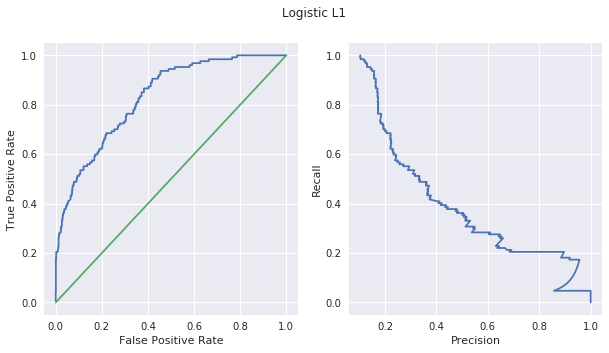

Logistic L2
AUC score: 0.7960794673393099
Log loss: 0.23179213412019778


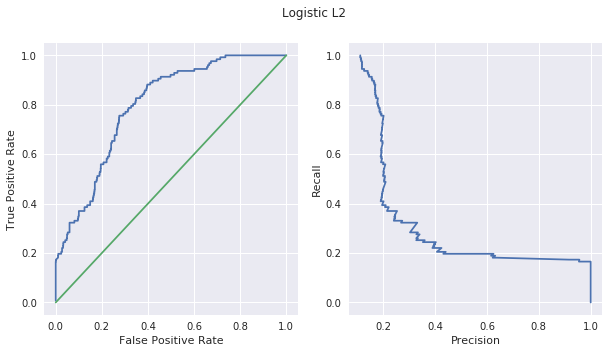

KNN
AUC score: 0.7361835452386634
Log loss: 1.0496367830982156


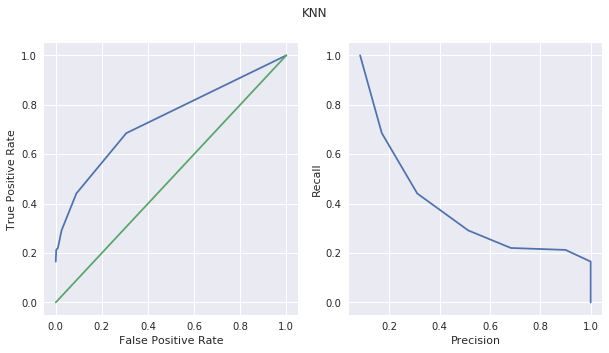

Tree
AUC score: 0.6690953403551828
Log loss: 3.636410411159606


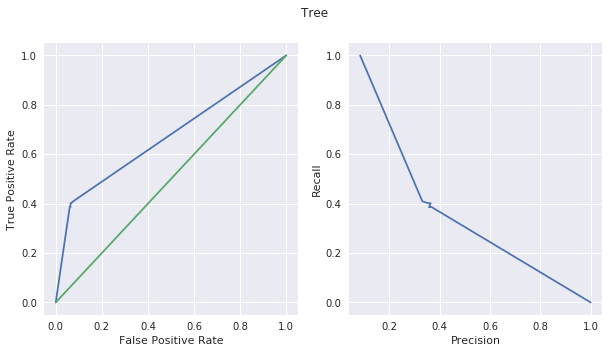

RandomForest
AUC score: 0.8879202599675041
Log loss: 0.19620564445145597


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


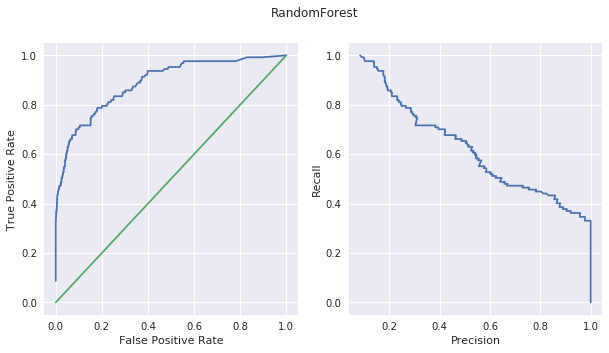

GradBoostTrees
AUC score: 0.8757996159570962
Log loss: 0.18649831913023684


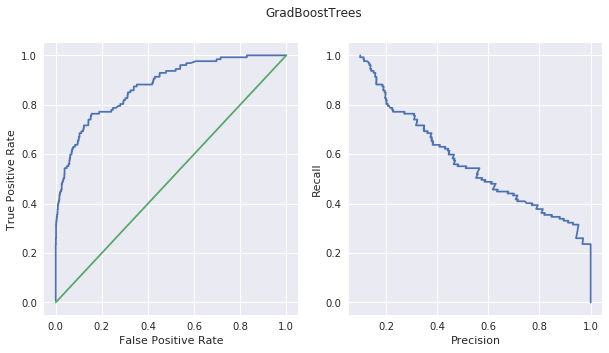

In [135]:
fit_models_noITT = fit_and_show_metrics(models_noITT, X_train, X_test, y_train, y_test)

In [136]:
sorted(list(zip(X.columns, fit_models_noITT['Logistic L1'].coef_[0])), key = lambda x: x[1], reverse=True)


[('demographics.race_ethnicity.unknown', 3.73128485810415),
 ('demographics.race_ethnicity.two_or_more', 2.4173031428197231),
 ('fafsa_sent.2_college_allyrs', 1.0583700442888928),
 ('3_yr_default_rate', 0.87137135644701125),
 ('pell_grant_rate', 0.71807016970323501),
 ('share_25_older', 0.6378418244416294),
 ('demographics.female_share', 0.5294242400467648),
 ('for_profit', 0.4512617585540511),
 ('religion_recode', 0.043423728503137436),
 ('location.lat', 0.0064983489166973571),
 ('location.lon', 0.0042180210528086131),
 ('branches', 0.0037339168757854783),
 ('tuition_revenue_per_fte', 1.8937573658773918e-05),
 ('instructional_expenditure_per_fte', 8.183919872676785e-06),
 ('institutional_characteristics.level', 0.0),
 ('federal_loan_rate', 0.0),
 ('demographics.dependent', 0.0),
 ('demographics.married', 0.0),
 ('demographics.race_ethnicity.aian', 0.0),
 ('demographics.race_ethnicity.asian', 0.0),
 ('demographics.race_ethnicity.black', 0.0),
 ('demographics.race_ethnicity.nhpi', 0.0),

In [137]:
sorted(list(zip(X.columns, fit_models_noITT['RandomForest'].feature_importances_)), key = lambda x: x[1], reverse=True)


[('branches', 0.05704784217742951),
 ('demographics.median_family_income', 0.047186093418861513),
 ('demographics.female_share', 0.046369829309781598),
 ('demographics.race_ethnicity.unknown', 0.041592608501469619),
 ('size', 0.039574428324478952),
 ('instructional_expenditure_per_fte', 0.038716716044513037),
 ('tuition_revenue_per_fte', 0.03757021598189618),
 ('3_yr_default_rate', 0.037162632063033427),
 ('location.lat', 0.037147825881684471),
 ('location.lon', 0.034955774935113551),
 ('share_lowincome.0_30000', 0.033585917968711965),
 ('share_middleincome.30001_48000', 0.032803291169148333),
 ('pell_grant_rate', 0.032388042850701265),
 ('demographics.dependent', 0.032267729900925107),
 ('share_independent_students', 0.032239616678036237),
 ('demographics.married', 0.030034996716226819),
 ('fafsa_sent.2_college_allyrs', 0.028016944299428685),
 ('share_firstgeneration', 0.025917681770417957),
 ('demographics.race_ethnicity.two_or_more', 0.025370108896023567),
 ('share_firstgeneration_p

#### Removing ITT Tech reduces the importance of branches

### Plot coefficients for logistic regression and feature importances for RandomForest

In [138]:
lasso_log_coef_names = [x[0] for x in lasso_log_coef if abs(x[1]) > 0.1]
lasso_log_coefs_imp = [x[1] for x in lasso_log_coef if abs(x[1]) > 0.1]

In [139]:
rf_feat_imp_names = [x[0] for x in rf_feat_imp if x[1] > 0.03]
rf_feat_imp_values = [x[1] for x in rf_feat_imp if x[1] > 0.03]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


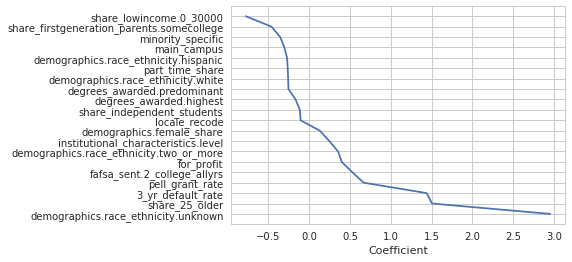

In [140]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(1)

ax.plot(lasso_log_coefs_imp, range(len(lasso_log_coef_names)))
plt.yticks(range(len(lasso_log_coef_names)), lasso_log_coef_names)
ax.set_xlabel("Coefficient")

fig.savefig('coefficients_lasso.png', fmt='png', dpi=600, bbox_inches='tight')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


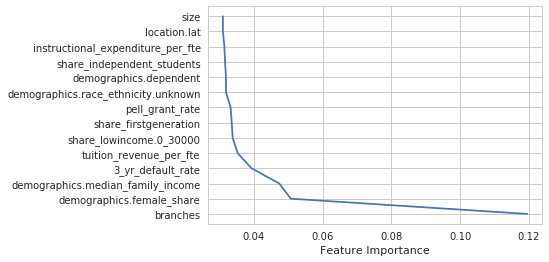

In [142]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(1)

ax.plot(rf_feat_imp_values, range(len(rf_feat_imp_names)))
plt.yticks(range(len(rf_feat_imp_names)), rf_feat_imp_names)
ax.set_xlabel("Feature Importance")

fig.savefig('featimp_rf.png', fmt='png', dpi=600, bbox_inches='tight')

### Combine predictions of Logistic Regression and Random Forest

Both models seem to be picking up on different features, so their geometric mean could work better.

In [143]:
X = cleaned_school_df.drop(['id', 'city', 'name', 'ownership', 'region_id', 'operating', 'not_operating'], axis = 1)
y = cleaned_school_df.not_operating
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [144]:
probRF = fit_models['RandomForest'].predict_proba(X_test)[:, 1]
probLog = fit_models['Logistic L1'].predict_proba(X_test)[:, 1]

In [145]:
prob_combined = (probRF * probLog)**0.5

Ensemble of Random Forest and Logistic Regression
AUC score: 0.8744065908893435
Log loss: 0.2749415845795845


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


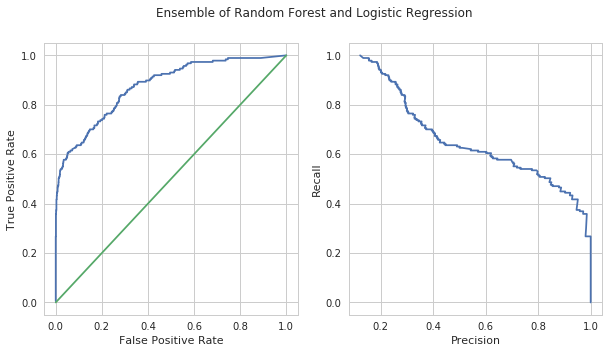

In [146]:
fpr, tpr, thresholds = roc_curve(y_test, prob_combined)
auc_score = integrate.trapz(tpr, x=fpr)

prec, recall, thresholds = precision_recall_curve(y_test, prob_combined)

model_ll = log_loss(y_test, prob_combined)
key = "Ensemble of Random Forest and Logistic Regression"
print(key)
print("AUC score: {}".format(auc_score))
print("Log loss: {}".format(model_ll))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(key)
axes[0].plot(fpr, tpr)
axes[0].plot(np.linspace(0,1,3),np.linspace(0,1,3))
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")

axes[1].plot(prec, recall)
axes[1].set_xlabel("Precision")
axes[1].set_ylabel("Recall")

plt.show()

### Sanity check: Look only main campuses 

In [147]:
campus_filter = (cleaned_school_df.branches >= 1) &\
                (cleaned_school_df.main_campus == 1) |\
                (cleaned_school_df.branches == 0)
main_campus_df = cleaned_school_df.loc[campus_filter]

In [148]:
main_campus_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5685 entries, 1 to 7702
Data columns (total 47 columns):
id                                                5685 non-null int64
location.lat                                      5685 non-null float64
location.lon                                      5685 non-null float64
branches                                          5685 non-null int64
city                                              5685 non-null object
degrees_awarded.highest                           5685 non-null int64
degrees_awarded.predominant                       5685 non-null int64
institutional_characteristics.level               5685 non-null int64
instructional_expenditure_per_fte                 5685 non-null float64
main_campus                                       5685 non-null int64
name                                              5685 non-null object
operating                                         5685 non-null int64
ownership                                    

In [149]:
X = main_campus_df.drop(['id', 'city', 'name', 'ownership', 'region_id', 'operating', 'not_operating'], axis = 1)
y = main_campus_df.not_operating

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [151]:
y_train.sum()/len(y_train), y_test.sum()/len(y_test)

(0.05255057167985928, 0.05364995602462621)

In [152]:
models_mc = dict()
models_mc['Logistic L1'] = LogisticRegression(penalty='l1', C = 0.5)
models_mc['RandomForest'] = RandomForestClassifier(n_estimators=1000)

Logistic L1
AUC score: 0.8496861478456945
Log loss: 0.16322043642774003


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


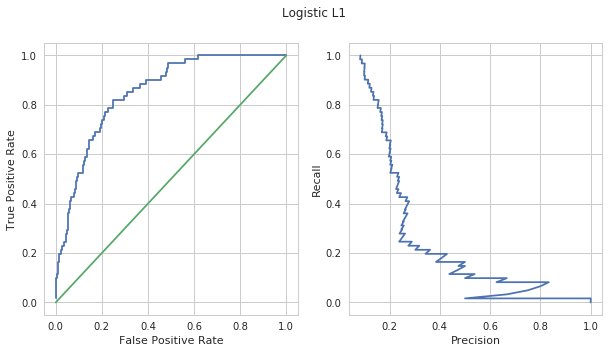

RandomForest
AUC score: 0.8873560241330978
Log loss: 0.15163414967551742


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


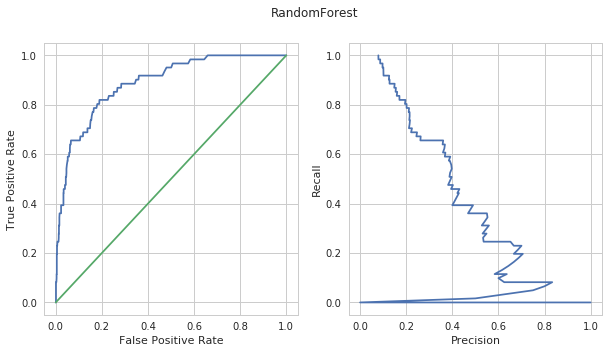

In [153]:
fit_models_mc = fit_and_show_metrics(models_mc, X_train, X_test, y_train, y_test)

In [154]:
probRF = fit_models_mc['RandomForest'].predict_proba(X_test)[:, 1]
probLog = fit_models_mc['Logistic L1'].predict_proba(X_test)[:, 1]

In [155]:
prob_combined_mc = (probRF * probLog)**0.5

Ensemble of Random Forest and Logistic Regression
AUC score: 0.888719605094765
Log loss: 0.15302989182758284


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


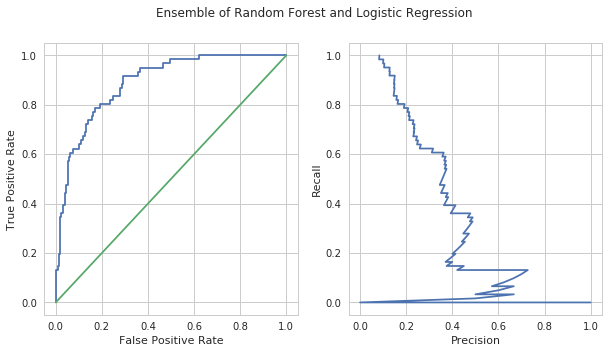

In [156]:
fpr, tpr, thresholds = roc_curve(y_test, prob_combined_mc)
auc_score = integrate.trapz(tpr, x=fpr)

prec, recall, thresholds = precision_recall_curve(y_test, prob_combined_mc)

model_ll = log_loss(y_test, prob_combined_mc)
key = "Ensemble of Random Forest and Logistic Regression"
print(key)
print("AUC score: {}".format(auc_score))
print("Log loss: {}".format(model_ll))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(key)
axes[0].plot(fpr, tpr)
axes[0].plot(np.linspace(0,1,3),np.linspace(0,1,3))
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")

axes[1].plot(prec, recall)
axes[1].set_xlabel("Precision")
axes[1].set_ylabel("Recall")

plt.show()

### Use ML insights to better understand random forest model

In [110]:
import ml_insights as mli

In [147]:
#mxr_rf = mli.ModelXRay(fit_models_noITT['RandomForest'],X_test)